# Testing

In this part, we test global effective dimension for different VQC structures.

- Number of qubits = 8
- Rotations = RY RZ
- Entanglement Map = Circular
- Number of layers = 2

In [1]:
# Necessary imports
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, RealAmplitudes, EfficientSU2
import matplotlib.pyplot as plt
import numpy as np

from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer, QuantumCircuit

from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA

from IPython.display import clear_output

# set random seed
algorithm_globals.random_seed = 42

In [2]:
#pip install qiskit[machine-learning]

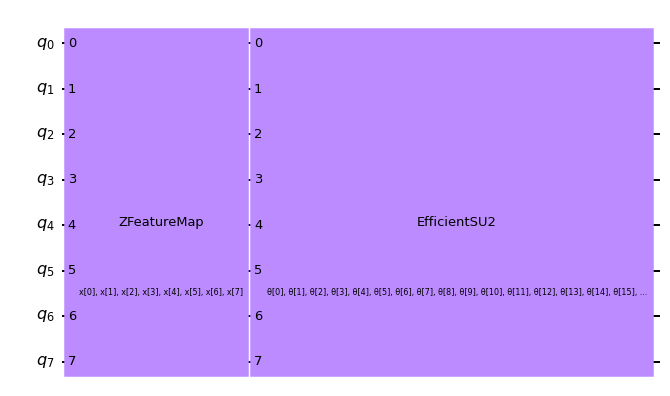

In [3]:
num_qubits = 8
# create a feature map
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)
# create a variational circuit
ansatz = EfficientSU2(num_qubits, su2_gates=['ry', 'rz'], entanglement='circular', reps=2)

# combine feature map and ansatz into a single circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))
qc.decompose().draw("mpl")

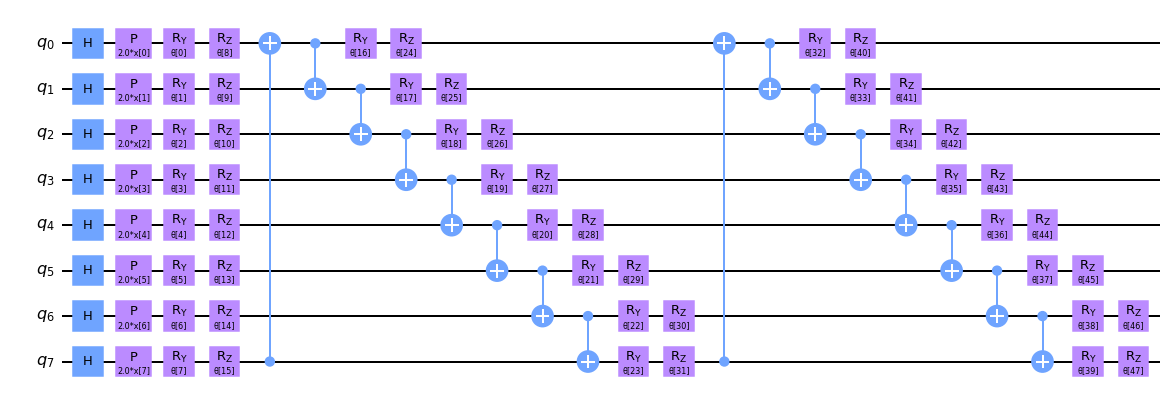

In [4]:
qc.decompose().decompose().draw("mpl")

In [5]:
# declare quantum instance
qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

In [6]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.


In [7]:
# construct QNN
qnn = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
    quantum_instance=qi_sv,
)

In [8]:
# we can set the total number of input samples and weight samples for random selection
num_input_samples = 10
num_weight_samples = 10

global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=num_weight_samples, input_samples=num_input_samples
)

In [9]:
# we can also provide user-defined samples and parameters
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

global_ed = EffectiveDimension(qnn=qnn, weight_samples=weight_samples, input_samples=input_samples)

In [10]:

# finally, we will define ranges to test different numbers of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

In [11]:
global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

In [12]:
d = qnn.num_weights

print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
print(
    "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
)

Data size: 5000, global effective dimension: 13.0414
Number of weights: 48, normalized effective dimension: 0.2717


In [13]:
global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)

In [14]:
print("Effective dimension: {}".format(global_eff_dim_1))
print("Number of weights: {}".format(d))

Effective dimension: [13.04141718 12.78355332 12.67548494 12.15243245 12.0351578  11.90398701
 11.81101783 11.75023156 11.58057843 11.47210181]
Number of weights: 48


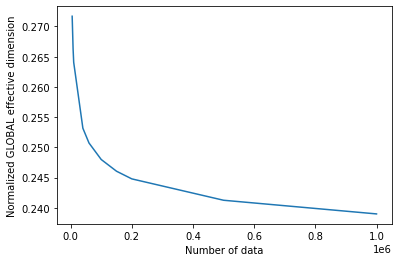

In [15]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(global_eff_dim_1) / d)
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.show()